# Compare logistic regression models of several mutations for a) covariates only and b) covariates with gene expression data to determine marginal gain using gene expression data 

In [47]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, grid_search
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer, FunctionTransformer
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.decomposition import PCA
from statsmodels.robust.scale import mad
from IPython.display import display
import gc
from IPython.core.debugger import Tracer

In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

## Load Data

In [3]:
%%time
path = os.path.join('..', '..', 'download', 'covariates.tsv')
covariates = pd.read_table(path, index_col=0)

CPU times: user 115 ms, sys: 14.5 ms, total: 130 ms
Wall time: 130 ms


In [30]:
%%time
path = os.path.join('..', '..', 'download', 'expression-matrix.tsv.bz2')
expression = pd.read_table(path, index_col=0)

CPU times: user 3min 21s, sys: 7.79 s, total: 3min 29s
Wall time: 3min 30s


In [4]:
%%time
path = os.path.join('..','..','download', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 1min 59s, sys: 5.13 s, total: 2min 4s
Wall time: 2min 6s


In [1]:
X = {}
X['model a'] = covariates
X['model b'] = pd.concat([covariates,expression], axis=1)
X['model c'] = expression
for k in ['model a','model b', 'model c']:
    print(X[k].shape)

NameError: name 'covariates' is not defined

In [32]:
# mutations = {
#     '5979': 'RET',    # ret proto-oncogene
#     '7428': 'VHL',    # von Hippel-Lindau tumor suppressor

# }
mutations = {
    '7157': 'TP53',   # tumor protein p53
    '7428': 'VHL',    # von Hippel-Lindau tumor suppressor
    '29126': 'CD274', # CD274 molecule
    '672': 'BRCA1',   # BRCA1, DNA repair associated
    '675': 'BRCA2',   # BRCA2, DNA repair associated
    '238': 'ALK',     # anaplastic lymphoma receptor tyrosine kinase
    '4221': 'MEN1',   # menin 1
    '5979': 'RET',    # ret proto-oncogene
}

## Define pipeline and Cross validation model fitting

In [33]:
# Parameter Sweep for Hyperparameters

param_grid = {
    'classify__loss': ['log'],
    'classify__penalty': ['elasticnet'],
    'classify__alpha': [10 ** x for x in range(-4, 2)],
    'classify__l1_ratio':  [0]
}


pipeline = Pipeline(steps=[
    ('impute', Imputer()),
    ('variance', VarianceThreshold()),
    ('standardize', StandardScaler()),
    ('classify', SGDClassifier(random_state=0, class_weight='balanced'))
])


In [34]:
cv_pipeline = {}
cv_pipeline['model a'] = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc')
cv_pipeline['model b'] = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc')
cv_pipeline['model c'] = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc')

## Functions to get statistics for a given model 

In [35]:
# Get statistics for a given model. 

def get_aurocs(X, y, pipeline, series, model_type):
    """
    Fit the classifier for the given mutation (y) and output predictions for it
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    pipeline.fit(X=X_train, y=y_train)
    y_pred_train = pipeline.decision_function(X_train)
    y_pred_test = pipeline.decision_function(X_test)
    cv_score_df, means = grid_scores_to_df(pipeline.grid_scores_)
    coeff_df = get_coeffs(pipeline, X_train, model_type)
    n_pos, n_neg = get_sign_coeffs(coeff_df)
    cov_ranks = get_ranks_covariates_feat(coeff_df)
    series['mean_cv_auroc'] = means['score'].max()
    series['training_auroc'] = roc_auc_score(y_train, y_pred_train)
    series['testing_auroc'] = roc_auc_score(y_test, y_pred_test)
    series['best_l1_ratio'] = pipeline.best_params_['classify__l1_ratio']
    series['best_alpha'] = pipeline.best_params_['classify__alpha']
    series['n_pos_coeffs'] = n_pos
    series['n_neg_coeffs'] = n_neg
    series['n_positive_mutation'] = sum(y==1)
    series['n_negative_mutation'] = sum(y==0)
    series['cum_rank_cov_feat'] = cov_ranks.sum()
    series['median_rank_cov_feat'] = np.median(cov_ranks)
    series['mean_rank_cov_feat'] = np.mean(cov_ranks)
    return series, means

def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to 
    a tidy pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    mean_rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            params = grid_score.parameters.copy()
            row = params
            row['fold'] = fold
            row['score'] = score
            rows.append(row)
        mean_row = {'l1_ratio': params['classify__l1_ratio'], 
                    'alpha': params['classify__alpha'],
                    'score': grid_score[1]}
        mean_rows.append(mean_row)
    df = pd.DataFrame(rows)
    means = pd.DataFrame(mean_rows)
    return df, means

def get_coeffs(pipeline, X_train, model_type):
    """
    Get a dataframe with the training coefficients 
    """
    final_pipeline = pipeline.best_estimator_
    final_classifier = final_pipeline.named_steps['classify']
    
    # Get indices of features
    if model_type == 'model a': 
        #select_indices = list(range(len(covariates.columns.values)))
        select_indices = final_pipeline.named_steps['variance'].transform(
            np.arange(len(X_train.columns)).reshape(1, -1)
        ).tolist()
    else:
#         select_indices = final_pipeline.named_steps['features'].transform(
#             np.arange(len(X_train.columns)).reshape(1, -1)
#         ).tolist()
        select_indices = final_pipeline.named_steps['variance'].transform(
            np.arange(len(X_train.columns)).reshape(1, -1)
        ).tolist()
        
    select_indices = [x for sublist in select_indices for x in sublist]
    
    # Make df features, weights
    coef_df = pd.DataFrame.from_items([
        ('feature', X_train.columns[select_indices]),
        ('weight', final_classifier.coef_[0]),
    ])

    return coef_df

def get_sign_coeffs(coef_df):
    return (coef_df.weight>0).sum(), (coef_df.weight<0).sum()

def get_ranks_covariates_feat(coef_df):
    coef_df['abs'] = coef_df['weight'].abs()
    coef_df = coef_df.sort_values('abs', ascending=False)
    
    def RepresentsInt(s):
        try: 
            int(s)
            return True
        except ValueError:
            return False

    coef_df['is_cov_feat'] = [not RepresentsInt(x) for x in coef_df['feature']]
    ranks = np.flatnonzero(coef_df['is_cov_feat'])
    return ranks

auroc_dfs = {}
all_cv_results = {}

## Train the models.

In [36]:
%%time
# Train model a: covariates only.
warnings.filterwarnings("ignore") # ignore deprecation warning for grid_scores_
rows = list()
cv_results = pd.DataFrame()
for m in list(mutations):
    series = pd.Series()
    series['mutation'] = m
    series['symbol'] = mutations[m]
    s, means = get_aurocs(X['model a'], Y[m], cv_pipeline['model a'], series, 'model a')
    means['symbol'] = mutations[m]
    cv_results = cv_results.append(means, ignore_index = True)
    rows.append(s)
auroc_dfs['model a'] = pd.DataFrame(rows)
auroc_dfs['model a'].sort_values(['symbol', 'testing_auroc'], ascending=[True, False], inplace=True)
all_cv_results['model a'] = cv_results 
display(auroc_dfs['model a'])
display(all_cv_results['model a'])

,mutation,symbol,mean_cv_auroc,training_auroc,testing_auroc,best_l1_ratio,best_alpha,n_pos_coeffs,n_neg_coeffs,n_positive_mutation,n_negative_mutation,cum_rank_cov_feat,median_rank_cov_feat,mean_rank_cov_feat
2,238,ALK,0.799114,0.851699,0.774443,0,0.100,34,36,138,7168,2415,34.5,34.5
4,672,BRCA1,0.805364,0.865053,0.771171,0,0.100,31,39,136,7170,2415,34.5,34.5
6,675,BRCA2,0.750242,0.814857,0.810296,0,0.100,35,35,237,7069,2415,34.5,34.5
1,29126,CD274,0.810410,0.930821,0.748213,0,0.001,18,52,19,7287,2415,34.5,34.5
7,4221,MEN1,0.758403,0.865684,0.768484,0,0.100,29,41,57,7249,2415,34.5,34.5
3,5979,RET,0.735751,0.800689,0.821134,0,10.000,32,38,117,7189,2415,34.5,34.5
5,7157,TP53,0.842233,0.846220,0.848195,0,0.100,32,38,2587,4719,2415,34.5,34.5
0,7428,VHL,0.946840,0.985475,0.976744,0,0.100,17,53,135,7171,2415,34.5,34.5


,alpha,l1_ratio,score,symbol
0,0.0001,0,0.920797,VHL
1,0.0010,0,0.916247,VHL
2,0.0100,0,0.936783,VHL
3,0.1000,0,0.946840,VHL
4,1.0000,0,0.944256,VHL
5,10.0000,0,0.940423,VHL
6,0.0001,0,0.775520,CD274
7,0.0010,0,0.810410,CD274
8,0.0100,0,0.721875,CD274
9,0.1000,0,0.724037,CD274


CPU times: user 18.7 s, sys: 985 ms, total: 19.7 s
Wall time: 9.97 s


In [37]:
%%time
# Train model b: covariates only.
warnings.filterwarnings("ignore") # ignore deprecation warning for grid_scores_
rows = list()
cv_results = pd.DataFrame()
for m in list(mutations):
    series = pd.Series()
    series['mutation'] = m
    series['symbol'] = mutations[m]
    s, means = get_aurocs(X['model b'], Y[m], cv_pipeline['model b'], series, 'model b')
    means['symbol'] = mutations[m]
    cv_results = cv_results.append(means, ignore_index = True)
    rows.append(s)
auroc_dfs['model b'] = pd.DataFrame(rows)
auroc_dfs['model b'].sort_values(['symbol', 'testing_auroc'], ascending=[True, False], inplace=True)
all_cv_results['model b'] = cv_results 
display(auroc_dfs['model b'])
display(all_cv_results['model b'])

,mutation,symbol,mean_cv_auroc,training_auroc,testing_auroc,best_l1_ratio,best_alpha,n_pos_coeffs,n_neg_coeffs,n_positive_mutation,n_negative_mutation,cum_rank_cov_feat,median_rank_cov_feat,mean_rank_cov_feat
2,238,ALK,0.707309,0.961314,0.739557,0,10.0,10072,10309,138,7168,652691,9587.5,9324.157143
4,672,BRCA1,0.678962,0.970446,0.698756,0,10.0,10110,10271,136,7170,695558,9564.5,9936.542857
6,675,BRCA2,0.661352,0.937379,0.708139,0,10.0,10111,10270,237,7069,694794,11106.5,9925.628571
1,29126,CD274,0.689757,0.937787,0.660665,0,0.1,9974,10407,19,7287,831097,13490.0,11872.814286
7,4221,MEN1,0.650251,0.995769,0.696348,0,1.0,10023,10358,57,7249,816021,13276.5,11657.442857
3,5979,RET,0.722377,0.971911,0.719563,0,10.0,10406,9975,117,7189,754394,11472.0,10777.057143
5,7157,TP53,0.929348,0.970331,0.933603,0,1.0,10887,9494,2587,4719,573714,8508.5,8195.914286
0,7428,VHL,0.955610,0.995437,0.980318,0,10.0,9626,10755,135,7171,790927,12210.0,11298.957143


,alpha,l1_ratio,score,symbol
0,0.0001,0,0.915899,VHL
1,0.0010,0,0.943526,VHL
2,0.0100,0,0.936428,VHL
3,0.1000,0,0.930809,VHL
4,1.0000,0,0.951282,VHL
5,10.0000,0,0.955610,VHL
6,0.0001,0,0.685642,CD274
7,0.0010,0,0.686526,CD274
8,0.0100,0,0.688812,CD274
9,0.1000,0,0.689757,CD274


CPU times: user 40min 9s, sys: 18min 32s, total: 58min 41s
Wall time: 57min 52s


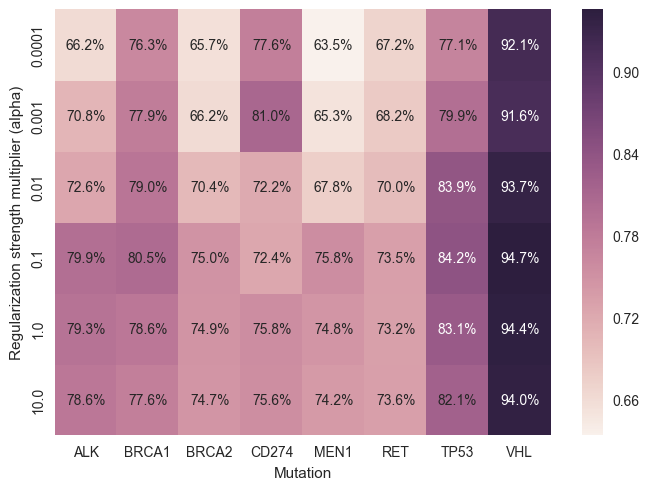

In [44]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(all_cv_results['model a'], values='score', index='alpha', columns='symbol')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Mutation')
ax.set_ylabel('Regularization strength multiplier (alpha)');

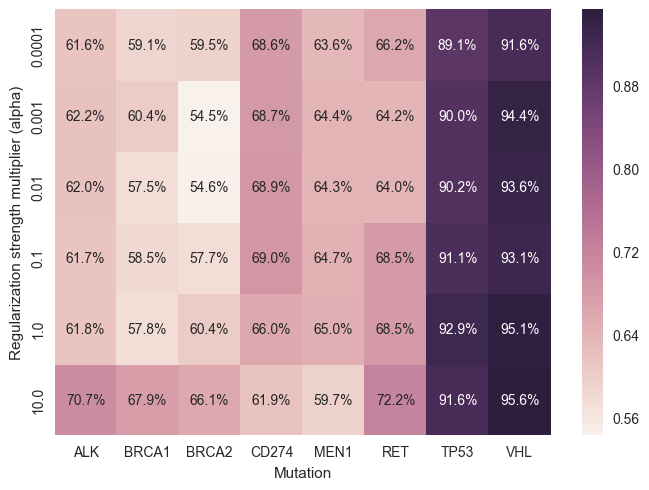

In [45]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(all_cv_results['model b'], values='score', index='alpha', columns='symbol')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Mutation')
ax.set_ylabel('Regularization strength multiplier (alpha)');

In [38]:
auroc_dfs['model a']['model'] = 'covariates_only'
auroc_dfs['model b']['model'] = 'combined'
auroc_df = pd.concat([auroc_dfs['model a'],auroc_dfs['model b']])
auroc_df.to_csv("./auroc_df.tsv", sep="\t", float_format="%.3g", index=False)
display(auroc_df)

,mutation,symbol,mean_cv_auroc,training_auroc,testing_auroc,best_l1_ratio,best_alpha,n_pos_coeffs,n_neg_coeffs,n_positive_mutation,n_negative_mutation,cum_rank_cov_feat,median_rank_cov_feat,mean_rank_cov_feat,model
2,238,ALK,0.799114,0.851699,0.774443,0,0.100,34,36,138,7168,2415,34.5,34.500000,covariates_only
4,672,BRCA1,0.805364,0.865053,0.771171,0,0.100,31,39,136,7170,2415,34.5,34.500000,covariates_only
6,675,BRCA2,0.750242,0.814857,0.810296,0,0.100,35,35,237,7069,2415,34.5,34.500000,covariates_only
1,29126,CD274,0.810410,0.930821,0.748213,0,0.001,18,52,19,7287,2415,34.5,34.500000,covariates_only
7,4221,MEN1,0.758403,0.865684,0.768484,0,0.100,29,41,57,7249,2415,34.5,34.500000,covariates_only
3,5979,RET,0.735751,0.800689,0.821134,0,10.000,32,38,117,7189,2415,34.5,34.500000,covariates_only
5,7157,TP53,0.842233,0.846220,0.848195,0,0.100,32,38,2587,4719,2415,34.5,34.500000,covariates_only
0,7428,VHL,0.946840,0.985475,0.976744,0,0.100,17,53,135,7171,2415,34.5,34.500000,covariates_only
2,238,ALK,0.707309,0.961314,0.739557,0,10.000,10072,10309,138,7168,652691,9587.5,9324.157143,combined
4,672,BRCA1,0.678962,0.970446,0.698756,0,10.000,10110,10271,136,7170,695558,9564.5,9936.542857,combined


In [39]:
auroc_dfs['model a'] = auroc_dfs['model a'].drop('model',axis=1)
auroc_dfs['model b'] = auroc_dfs['model b'].drop('model',axis=1)
auroc_dfs['diff_models_ab'] = auroc_dfs['model b'].loc[:,'mean_cv_auroc':]-auroc_dfs['model a'].loc[:,'mean_cv_auroc':]
auroc_dfs['diff_models_ab'][['mutation', 'symbol']] = auroc_dfs['model b'].loc[:, ['mutation', 'symbol']]
auroc_dfs['diff_models_ab']

,mean_cv_auroc,training_auroc,testing_auroc,best_l1_ratio,best_alpha,n_pos_coeffs,n_neg_coeffs,n_positive_mutation,n_negative_mutation,cum_rank_cov_feat,median_rank_cov_feat,mean_rank_cov_feat,mutation,symbol
2,-0.091806,0.109615,-0.034886,0,9.900,10038,10273,0,0,650276,9553.0,9289.657143,238,ALK
4,-0.126403,0.105393,-0.072415,0,9.900,10079,10232,0,0,693143,9530.0,9902.042857,672,BRCA1
6,-0.088890,0.122522,-0.102157,0,9.900,10076,10235,0,0,692379,11072.0,9891.128571,675,BRCA2
1,-0.120652,0.006966,-0.087548,0,0.099,9956,10355,0,0,828682,13455.5,11838.314286,29126,CD274
7,-0.108152,0.130084,-0.072136,0,0.900,9994,10317,0,0,813606,13242.0,11622.942857,4221,MEN1
3,-0.013374,0.171222,-0.101571,0,0.000,10374,9937,0,0,751979,11437.5,10742.557143,5979,RET
5,0.087115,0.124111,0.085408,0,0.900,10855,9456,0,0,571299,8474.0,8161.414286,7157,TP53
0,0.008770,0.009963,0.003574,0,9.900,9609,10702,0,0,788512,12175.5,11264.457143,7428,VHL


# Covariates only vs covariates+expression model

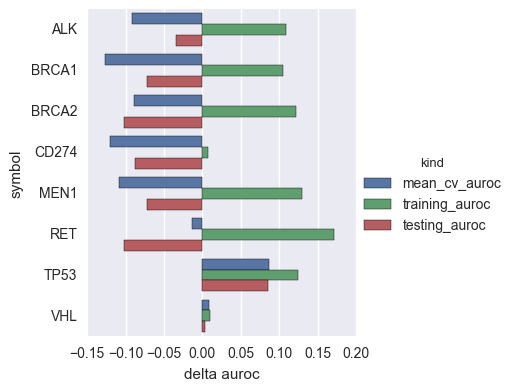

In [40]:
plot_df = pd.melt(auroc_dfs['diff_models_ab'], id_vars='symbol', value_vars=['mean_cv_auroc', 'training_auroc', 'testing_auroc'], var_name='kind', value_name='delta auroc')
grid = sns.factorplot(y='symbol', x='delta auroc', hue='kind', data=plot_df, kind="bar")